In [1]:
import numpy as np
import random
from DeepESN import DeepESN
from utils import MSE, load_chest, select_indexes
class Struct(object): pass
from sklearn.model_selection import ParameterGrid
import copy
import csv
import time


np.random.seed(7)

In [11]:
def train(Nr, Nl, reg, transient, rhos, lis, iss, con):
    configs = Struct()
 
    configs.rhos = rhos
    configs.lis = lis
    configs.iss = iss

    configs.IPconf = Struct()
    configs.IPconf.DeepIP = 0 # deactivate pre-train

    configs.reservoirConf = Struct()
    configs.reservoirConf.connectivity = con 

    configs.readout = Struct()
    configs.readout.trainMethod = 'SVD' # train with singular value decomposition (more accurate)
    configs.readout.regularizations = 10.0**np.array(range(-16,-1,1))

    deepESN = DeepESN(Nu, Nr, Nl, configs)
    states = deepESN.computeState(dataset.inputs, deepESN.IPconf.DeepIP)
        
    train_states = select_indexes(states, list(TR_indexes) + list(VL_indexes), transient)
    train_targets = select_indexes(dataset.targets, list(TR_indexes) + list(VL_indexes), transient)
    test_states = select_indexes(states, TS_indexes)
    test_targets = select_indexes(dataset.targets, TS_indexes)
    
    deepESN.trainReadout(train_states, train_targets, reg)

    return score(deepESN, train_states, test_states, test_targets), test_targets[0].tolist()

In [3]:
def score(deepESN, train_states, test_states, test_targets):
    #compute error SIGNAL FED
    test_states_std = copy.deepcopy(test_states)
    test_outputs_std = deepESN.computeOutput(test_states_std)
    test_error_std = MSE(test_outputs_std, test_targets)

    #compute error SELF FED
    test_outputs = []
    state = [train_states[0][:,-1:]] #set last training state as initial state
    output = [np.array(deepESN.computeOutput(state))] #set last training output as initial output
    for t in range(len(test_states[0][0])):
        state = deepESN.computeState(inputs=output, DeepIP=0, initialStates=state[0])
        output = deepESN.computeOutput(state)
        test_outputs.append(output[0][0])
        output = [np.array(output)]
#             if t % 3000 == 0:
#                 print(t)
#                 print(output)

    test_error = MSE(np.array(test_outputs), np.array(test_targets))
    return test_error, test_outputs, test_error_std, test_outputs_std[0].tolist()

In [62]:
test = train(10, 2, 0.00, 100, 0.9, 1.0, 0.1, 1)

In [4]:
#construct parameter grid

#set parameter ranges for sweep
parameters = {
    "Nr": [10, 100, 200],          # number of recurrent units
    "Nl": [1, 2, 5, 10],                     # number of recurrent layers
    "reg": [0.01, 0.1, 1.0, 10],                  # regularization of svd
    "transient": [1000],                 # washout
    "rhos": [0.8, 1.0, 1.2, 3.0, 5.0],       # set spectral radius for all recurrent layers
    "lis": [0.1, 0.2, 0.5],            # set leaky rate for all recurrent layers
    "iss": [1.0],               # set input scale for all recurrent layers
    "con": [0.2, 0.5, 1.0],                 # connectivity of recurrent matrix
    ".sampling": [1, 10, 30]             # set step size for sampling, 1 is no sampling. be careful not to make dataset too small
}

data_size = 20000 # pick dataset length to run parameter sweep on

if 640640/max(parameters[".sampling"]) < data_size:
    print("WARNING: highest sampling rate means that resulting dataset is smaller than data_size. \n")

print("Training data length: " + str(int(data_size*0.5)) + "  Validating data length: " + str(int(data_size*0.5)))

search_space = ParameterGrid(parameters)
print("number of models to be swept over: " + str(len(search_space)))
for i in range(10):
    print(search_space[i])
    

Training data length: 10000  Validating data length: 10000
number of models to be swept over: 6480
{'transient': 1000, 'rhos': 0.8, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.2, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 3.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 5.0, 'reg': 0.01, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 0.8, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.0, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr': 10, 'Nl': 1, '.sampling': 1}
{'transient': 1000, 'rhos': 1.2, 'reg': 0.1, 'lis': 0.1, 'iss': 1.0, 'con': 0.2, 'Nr

In [5]:
#make random short list to test sweep on
search_space_short = []
for i in range(1):
    index = round(random.random() * len(search_space))
    search_space_short.append(search_space[index])
    
search_space_short = sorted(search_space_short, key=lambda k: k['.sampling'])
search_space_short

[{'transient': 1000,
  'rhos': 1.0,
  'reg': 10,
  'lis': 0.5,
  'iss': 1.0,
  'con': 1.0,
  'Nr': 10,
  'Nl': 1,
  '.sampling': 10}]

In [8]:
#turn full parameter grid to list.
search_space_short = []
for i in range(len(search_space)):
    search_space_short.append(search_space[i])
    
search_space_short = sorted(search_space_short, key=lambda k: k['.sampling'])
len(search_space_short)

5832

In [10]:
# run the parameter sweep
start = time.time()
results = []
targets = []
previous = None

for i, args in enumerate(search_space_short):
    if args[".sampling"] != previous:
        #update dataset with new sampling rate
        dataset, Nu, TR_indexes, VL_indexes, TS_indexes = load_chest('datasets', data_size, args[".sampling"])
        
    output, test_targets = train(Nr=args['Nr'], Nl=args['Nl'], reg=args['reg'], transient=args['transient'], rhos=args['rhos'], lis=args['lis'], iss=args['iss'], con=args['con'])
    results.append(output)
    if args[".sampling"] != previous:
        targets.append([args[".sampling"], test_targets])
        previous = args[".sampling"]
    if i % 1000 == 0:
        print(i)

print("average time taken: " + str((time.time()-start)/len(search_space_short)))

input length =  19999
.7 =  13999
.8 =  15999
-1 =  19998
Done loading data
0
average time taken: 1.4005444049835205


In [11]:
#csv export
keys = []
for key in search_space_short[0].keys():
    keys.append(key)
keys.append("MSE")
keys.append("outputs")
keys.append("MSE_std")
keys.append("outputs_std")

header = keys

with open('results.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(header)

    for i in range(len(search_space_short)):
        vals = []
        for val in search_space_short[i].values():
            vals.append(val)
        for j in range(len(results[0])):
            vals.append(results[i][j])
        write.writerow(vals)

        
with open('targets.csv', 'w') as f:
    write = csv.writer(f)
    header = ["sampling rate", "test_targets"]
    write.writerow(header)
    
    for row in targets:
        write.writerow(row)


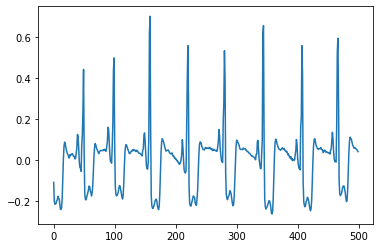

In [81]:
import matplotlib.pyplot as plt

# 012
# 354

# results[1][1]
plt.plot(targets[1][1][0][0][:500])

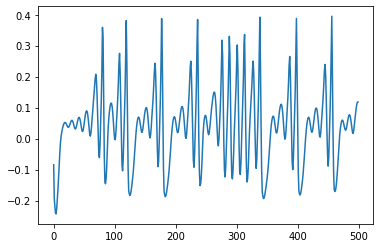

In [83]:
plt.plot(results[5][1][:500])

In [8]:
results_np = np.array(results)

<ipython-input-8-1292471a3633>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_np = np.array(results)


In [15]:
np.amin(results_np[:,2])

np.where(results_np == np.amin(results_np[:,0]))

(array([1], dtype=int64), array([0], dtype=int64))

In [7]:
targets[0]

[10,
 [[-0.10931396484375,
   -0.2005462646484375,
   -0.21624755859375,
   -0.214508056640625,
   -0.2117156982421875,
   -0.1985321044921875,
   -0.1945953369140625,
   -0.1772918701171875,
   -0.1846160888671875,
   -0.1901092529296875,
   -0.2127227783203125,
   -0.240142822265625,
   -0.241973876953125,
   -0.2325897216796875,
   -0.1822357177734375,
   -0.0776824951171875,
   0.0102081298828125,
   0.068939208984375,
   0.087066650390625,
   0.07745361328125,
   0.0600128173828125,
   0.046417236328125,
   0.0353851318359375,
   0.0271453857421875,
   0.0225677490234375,
   0.0092010498046875,
   0.0135955810546875,
   0.0270538330078125,
   0.0231170654296875,
   0.0252227783203125,
   0.0302581787109375,
   0.0296173095703125,
   0.0211029052734375,
   0.0166168212890625,
   0.0170745849609375,
   0.004852294921875,
   0.0098419189453125,
   0.0359344482421875,
   0.0584564208984375,
   0.12469482421875,
   0.1170501708984375,
   0.0611114501953125,
   -0.007965087890625,
   -0